## Téléchargement de la base de données

In [182]:
# Pour récupérer le nombre de classes du training dataset
from tensorflow import keras
import os
from keras import layers

In [183]:
IMG_SIZE = 128
DIRECTORY = "/home/basile/Documents/projet_bees_detection_basile/data_bees_detection/resnet_2_species/"
train_ds = keras.utils.image_dataset_from_directory(
    directory= os.path.join(DIRECTORY, 'train'),
    labels='inferred',
    label_mode='categorical',
    shuffle = False,
    batch_size=16,
    image_size=(IMG_SIZE, IMG_SIZE))

Found 25 files belonging to 2 classes.


In [184]:
CLASS_NAMES = train_ds.class_names
print(CLASS_NAMES)
NB_CLASSES = len(CLASS_NAMES)
print(NB_CLASSES)

['Apis mellifera', 'Bombus terrestris']
2


## Chargement des données

In [185]:
from tensorflow import keras
from keras import layers

In [186]:
# Récupération des dataset pour l'entraînement (train, val)
train_ds = keras.utils.image_dataset_from_directory(
    directory= os.path.join(DIRECTORY, 'train'),
    labels='inferred',
    label_mode='categorical',
    shuffle = False,
    batch_size=16,
    image_size=(IMG_SIZE, IMG_SIZE))

validation_ds = keras.utils.image_dataset_from_directory(
    directory= os.path.join(DIRECTORY, 'validation'),
    labels='inferred',
    label_mode='categorical',
    batch_size=16,
    image_size=(IMG_SIZE, IMG_SIZE))

test_ds = keras.utils.image_dataset_from_directory(
    directory= os.path.join(DIRECTORY, 'test'),
    labels='inferred',
    label_mode='categorical',
    batch_size=16,
    image_size=(IMG_SIZE, IMG_SIZE))


Found 25 files belonging to 2 classes.
Found 7 files belonging to 2 classes.
Found 8 files belonging to 2 classes.


## Création du modèle

In [187]:
import numpy as np

x_train = np.array(train_ds.file_paths)
y_train = np.zeros((len(x_train), NB_CLASSES))

ind_data = 0
for bx, by in train_ds.as_numpy_iterator():
  y_train[ind_data:ind_data+bx.shape[0]] = by
  ind_data += bx.shape[0]

In [188]:
def color_preprocessing(x):
    x = x.astype('float32')
    mean = [125.3, 123.0, 113.9]
    std  = [63.0,  62.1,  66.7]
    for i in range(3):
        x[:,:,:,i] = (x[:,:,:,i] - mean[i]) / std[i]
    return x

In [189]:
from keras.utils import Sequence
import numpy as np
import cv2 as cv

class AbeillesSequence(Sequence):
    
    # Initialisation de la séquence avec différents paramètres
    def __init__(self, x_train, y_train, batch_size):
        self.x_train = x_train
        self.y_train = y_train
        self.classes = CLASS_NAMES
        self.batch_size = batch_size
        self.indices1 = np.arange(len(x_train))

        np.random.shuffle(self.indices1) # Les indices permettent d'accéder
        # aux données et sont randomisés à chaque epoch pour varier la composition
        # des batches au cours de l'entraînement

    # Fonction calculant le nombre de pas de descente du gradient par epoch
    def __len__(self):
        return int(np.ceil(x_train.shape[0] / float(self.batch_size)))
    
    def _read_img(self, path):
        img = cv.imread(path)
        img = cv.resize(img, (IMG_SIZE, IMG_SIZE))
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        return img
   

    # Fonction appelée à chaque nouveau batch : sélection et augmentation des données
    # idx = position du batch (idx = 5 => on prend le 5ème batch)
    def __getitem__(self, idx):
        # Sélection des données dans le dataset
        batch_x = self.x_train[self.indices1[idx * self.batch_size:(idx + 1) * self.batch_size]]
        batch_y = self.y_train[self.indices1[idx * self.batch_size:(idx + 1) * self.batch_size]]

        # lecture des images

        batch_x = np.array([self._read_img(path) for path in batch_x])

        print(batch_x.shape)
           
        # Normalisation des données
        batch_x = color_preprocessing(batch_x)
        
        return batch_x, batch_y

    # Fonction appelée à la fin d'un epoch ; on randomise les indices d'accès aux données
    def on_epoch_end(self):
        np.random.shuffle(self.indices1)

In [190]:
from keras import regularizers
from keras import optimizers
import tensorflow as tf

In [191]:
from tensorflow import keras 
import numpy as np
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization
from keras.layers import Conv2D, Dense, Input, add, Activation, Flatten, AveragePooling2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D
from keras.callbacks import LearningRateScheduler, TensorBoard
from keras.regularizers import l2
from keras import optimizers
from keras.models import Model

WEIGHT_DECAY = 0.0005

def create_WideResNet50(width=1, img_rows=224, img_cols=224, img_channels=3, nb_classes=1000):

  # Input
  img_input = Input(shape=(img_rows,img_cols,img_channels))

  # first_filter : nb de filtres de la première conv
  # reduction : True si on doit diviser la dimension de l'entrée
  def residual_layer(input, first_filter, reduction=False, first_layer=False):

    conv = Conv2D(filters=width*first_filter, kernel_size=(1,1), strides=(1,1),
        kernel_initializer='he_normal',
        kernel_regularizer=l2(WEIGHT_DECAY))(input)
    conv = BatchNormalization(momentum=0.9, epsilon=1e-5)(conv)
    conv = Activation('relu')(conv)

    if (reduction):
      conv = Conv2D(filters=width*first_filter, kernel_size=(3,3), strides=(2,2), padding='same',
              kernel_initializer='he_normal',
              kernel_regularizer=l2(WEIGHT_DECAY))(conv)
    else:
      conv = Conv2D(filters=width*first_filter, kernel_size=(3,3), strides=(1,1), padding='same',
              kernel_initializer='he_normal',
              kernel_regularizer=l2(WEIGHT_DECAY))(conv)
    conv = BatchNormalization(momentum=0.9, epsilon=1e-5)(conv)
    conv = Activation('relu')(conv)

    conv = Conv2D(filters=4*first_filter, kernel_size=(1,1), strides=(1,1),
            kernel_initializer='he_normal',
            kernel_regularizer=l2(WEIGHT_DECAY))(conv)
    conv = BatchNormalization(momentum=0.9, epsilon=1e-5)(conv)

    if (first_layer):
      conv2 = Conv2D(filters = 256, kernel_size=(1,1), strides=(1,1),
          kernel_initializer='he_normal',
          kernel_regularizer=l2(WEIGHT_DECAY))(x)
      conv2 = BatchNormalization(momentum=0.9, epsilon=1e-5)(conv2)
    else:
      if (reduction):
        conv2 = Conv2D(filters = 4*first_filter, kernel_size=(1,1), strides=(2,2),
                kernel_initializer='he_normal',
                kernel_regularizer=l2(WEIGHT_DECAY))(x)
        conv2 = BatchNormalization(momentum=0.9, epsilon=1e-5)(conv2)
      else:
        conv2 = input
    
    return add([conv, conv2])
  
  x = ZeroPadding2D(padding=(3,3))(img_input)
  x = Conv2D(filters=64, kernel_size=(7,7), strides=(2,2),
        kernel_initializer='he_normal',
        kernel_regularizer=l2(WEIGHT_DECAY))(x)
  x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x)
  x = Activation('relu')(x)
  x = ZeroPadding2D(padding=(1,1))(x)
  x = MaxPooling2D(pool_size=(3, 3), strides=(2,2))(x)

  # Premier bloc résiduel
  x = residual_layer(x, 64, reduction=False, first_layer=True)
  for i in range(2): 
    x = Activation('relu')(x)
    x = residual_layer(x, 64, reduction=False)

  # Second bloc
  x = Activation('relu')(x)
  x = residual_layer(x, 128, reduction=True)
  for i in range(3): 
    x = Activation('relu')(x)
    x = residual_layer(x, 128, reduction=False)
  
  # Troisième bloc
  x = Activation('relu')(x)
  x = residual_layer(x, 256, reduction=True)
  for i in range(5): 
    x = Activation('relu')(x)
    x = residual_layer(x, 256, reduction=False)

  # Quatrième bloc
  x = Activation('relu')(x)
  x = residual_layer(x, 512, reduction=True)
  for i in range(2): 
    x = Activation('relu')(x)
    x = residual_layer(x, 512, reduction=False)

  x = GlobalAveragePooling2D()(x)
  x = Flatten()(x)
  x = Dense(nb_classes,
      activation='softmax',
      kernel_initializer='he_normal',
      kernel_regularizer=l2(WEIGHT_DECAY))(x)
  
  return Model(img_input, x)

In [192]:
# model = create_WideResNet50(width=2, img_rows=128, img_cols=128, img_channels=3, nb_classes=NB_CLASSES)
# model.summary()

In [193]:
# create a vgg16 "model"
from keras.applications.vgg16 import VGG16

# load the model with imagenet weights
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# freeze the layers
for layer in vgg16.layers:
    layer.trainable = False

# add new classifier layers
flat1 = Flatten()(vgg16.layers[-1].output)
class1 = Dense(1024, activation='relu', kernel_initializer='he_uniform')(flat1)
output = Dense(NB_CLASSES, activation='softmax')(class1)

# define new model

model = Model(inputs=vgg16.inputs, outputs=output)

In [194]:
# Ajout de l'optimiseur, de la fonction coût et des métriques
model.compile(tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9), loss='categorical_crossentropy', metrics=['categorical_accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [195]:
# Les callbacks
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath='./model_checkpoint_wide_resnet50.h5',
    save_weights_only=True,
    monitor='val_categorical_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_categorical_accuracy",
    min_delta=0.01,
    patience=10,
    verbose=1,
    mode="auto")

reduce_lr_cb = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.1,
                              patience=5, min_lr=0.00001, verbose=1)

In [196]:

train_ds_aug = AbeillesSequence(x_train, y_train, batch_size=16)

In [197]:
import numpy as np
import tensorflow as tf

len_val = len(validation_ds.file_paths)

# Normalisation des données de validation
x_val = np.zeros((len_val, IMG_SIZE, IMG_SIZE, 3))
y_val = np.zeros((len_val, NB_CLASSES))

ind_data = 0
for bx, by in validation_ds.as_numpy_iterator():
  x_val[ind_data:ind_data+bx.shape[0]] = bx
  y_val[ind_data:ind_data+bx.shape[0]] = by
  ind_data += bx.shape[0]

x_val = color_preprocessing(x_val)

In [198]:
max,min, mean, std = np.max(x_val), np.min(x_val), np.mean(x_val), np.std(x_val)

print("max : ", max)
print("min : ", min)
print("mean : ", mean)
print("std : ", std)

max :  2.125604
min :  -1.988889
mean :  -0.31558636
std :  1.1168293


In [199]:
# Sans pondération des classes
history = model.fit(train_ds_aug, epochs=150, validation_data = (x_val, y_val), callbacks=[model_checkpoint_cb, early_stopping_cb, reduce_lr_cb])
# Avec pondération des classes
#model.fit(train_ds_aug, epochs=150, validation_data = (x_val, y_val), callbacks=[model_checkpoint_cb, early_stopping_cb, reduce_lr_cb], class_weight=class_weight)

(16, 128, 128, 3)
Epoch 1/150
(9, 128, 128, 3)
(16, 128, 128, 3)
2/2 [==============================] - ETA: 0s - loss: 0.6786 - categorical_accuracy: 0.5600 - precision_10: 0.5600 - recall_10: 0.5600
Epoch 1: val_categorical_accuracy improved from -inf to 0.28571, saving model to ./model_checkpoint_wide_resnet50.h5
2/2 [==============================] - 1s 378ms/step - loss: 0.6786 - categorical_accuracy: 0.5600 - precision_10: 0.5600 - recall_10: 0.5600 - val_loss: 0.9530 - val_categorical_accuracy: 0.2857 - val_precision_10: 0.2857 - val_recall_10: 0.2857 - lr: 0.0010
Epoch 2/150
(9, 128, 128, 3)
(16, 128, 128, 3)
2/2 [==============================] - ETA: 0s - loss: 0.5078 - categorical_accuracy: 0.8000 - precision_10: 0.8000 - recall_10: 0.8000
Epoch 2: val_categorical_accuracy did not improve from 0.28571
2/2 [==============================] - 0s 125ms/step - loss: 0.5078 - categorical_accuracy: 0.8000 - precision_10: 0.8000 - recall_10: 0.8000 - val_loss: 1.3170 - val_categoric

In [200]:
import matplotlib.pyplot as plt
def plot_training_analysis(history, metric='loss'):    

  loss = history.history[metric]
  val_loss = history.history['val_' + metric]

  epochs = range(len(loss))

  plt.plot(epochs, loss, 'b', linestyle="--",label='Training ' + metric)
  plt.plot(epochs, val_loss, 'g', label='Validation ' + metric)
  plt.title('Training and validation ' + metric)
  plt.legend()

  plt.show()

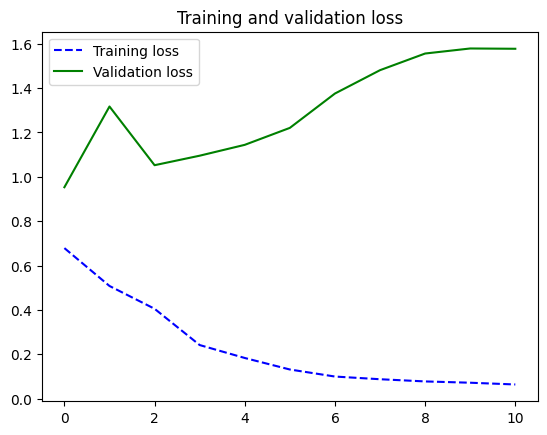

In [203]:
plot_training_analysis(history)